<a href="https://colab.research.google.com/github/ArghaSarker/reinforcement-learning-homework-summer-2023/blob/main/homework02/GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt

In [83]:
class GridWorld():
    UP = (+1,  0)
    DOWN  = (-1, 0)
    LEFT = ( 0, -1)
    RIGHT  = ( 0, +1)
    ACTIONS = [UP, DOWN, LEFT, RIGHT]
    AGENT_START = (0,0)
    
    def __init__(self, shape, probability, walls, traps, difficult, goal):
        self.rows, self.cols = shape
        self.probability = probability
        self.walls = set(walls)
        self.traps = set(traps)
        self.difficult = set(difficult)
        self.goal = goal
        self.agent_state = GridWorld.AGENT_START

        self.grid = np.zeros((self.rows, self.cols))
        self.grid[self.goal[0], self.goal[1]] = 1

        for wall in self.walls:
            self.grid[wall[0], wall[1]] = 1
            
        for trap in self.traps:
            self.grid[trap[0], trap[1]] = 1
            
        for tile in self.difficult:
            self.grid[tile[0], tile[1]] = 1

    # code for displaying the created grid world
    def displayGridWorld(self):
      """
        Displays the grid world.
          
        Args:
            No arguments required.
          
        Returns:
            Prints the grid world.
      """
      for i in range(self.rows):
        for j in range(self.cols):
            if (i, j) == self.agent_state:
                print("A", end=' ')
            elif (i, j) == self.goal:
                print("G", end=' ')
            elif (i, j) in self.walls:
                print("X", end=' ')
            elif (i, j) in self.traps:
                print("T", end=' ')
            elif (i, j) in self.difficult:
                print("D", end=' ')
            else:
                print(".", end=' ')
        print()

    def _getStates(self):
      """
        Returns all reachable states.
          
        Args:
            No arguments required.
          
        Returns:
            All the possible states for the agent
      """
      return [(i, j) for i in range(self.rows)
                  for j in range(self.cols) if (i, j) not in self.walls and (i, j) not in self.traps]
    
    # currently not needed thus no documentation
    def getProbsGivenState(self, state, action):
        transition_probabilities = {}

        for x in range(self.rows):
            for y in range(self.cols):
                state = (x, y)
                for ACTIONS in GridWorld.ACTIONS:
                    new_x = state[0] + action[0]
                    new_y = state[1] + action[1]
                    next_state = (new_x if 0 <= new_x < self.rows else state[0], new_y if 0 <= new_y < self.cols else state[1])
                    transition_probabilities[(state, action)] = [(next_state, self.probability)]

        return transition_probabilities

    def _getReward(self, state):
      """
        Calculates the reward that the agent receives for a given state.
          
        Args:
            state: The state the agent ends up in after doing it's move.
          
        Returns:
            The reward for the agent is returned.
      """
      if state in self.goal:
        return 100
      elif state in self.traps:
        return -1.0
      elif state in self.walls:
        return -0.5
      elif state in self.difficult:
        return -0.4
      else:
        return 0.0

    def _is_done(self, state):
      """
        Checks whether or not the agent is done with it's current episode.
          
        Args:
            state: The state the agent ends up in after doing it's move.
          
        Returns:
            A boolean indicating whether or not the agent is done.
      """
      return state == self.goal or state in self.traps or state in self.walls

    def _moveAgent(self, state, action):
      """
        Moves the Agent in the Grid World.
          
        Args:
            state: The agent's current state.
            action: The action that the action is supposed to take.
          
        Returns:
            The agent's next state, the reward received for the action and whether the agent is done with the current epsiode or not.
      """
      new_x = state[0] + action[0]
      new_y = state[1] + action[1]
      next_state = (new_x if 0 <= new_x < self.rows else state[0], new_y if 0 <= new_y < self.cols else state[1])
        
      reward = self._getReward(next_state)
      is_done = self._is_done(next_state)

      if next_state in self.walls or next_state in self.traps:
        next_state = state

      return next_state, reward, is_done

    def _resetWorld(self):
      """
        Resets the grid world.
          
        Args:
            No arguments are needed.
          
        Returns:
            The world is reset internally, thus nothing is returned.
      """
      self.agent_state = GridWorld.AGENT_START

    def _construct_epsilon_greedy_policy(self, Q_value, epsilon, no_actions):
      """
        Creates an epsilon-greedy policy based on a given Q-function and epsilon.
          
        Args:
            Q: A dictionary that maps from state -> action-values.
                Each value is a numpy array of length nA (see below)
            epsilon: The probability to select a random action . float between 0 and 1.
            no_actions: The number of available actions.
          
        Returns:
            A policy function that takes a state as an argument and returns the probabilites for all the actions as a numpy array.
            The policy also supports annealing of epsilon during training.
            Note that the policy is implicitly improved by looking up the best action in the Q_value.

        The idea to return the policy as a function was inspired by this source https://github.com/dennybritz/reinforcement-learning/blob/master/MC/MC%20Control%20with%20Epsilon-Greedy%20Policies%20Solution.ipynb
      """
      def greedy_policy(state, no_episode=1):
        action_probs = np.ones(no_actions, dtype=float) * epsilon**no_episode / no_actions
        best_action = np.argmax(Q_value[state])
        action_probs[best_action] += (1.0 - epsilon**no_episode)
        return action_probs

      return greedy_policy

        
    def monte_carlo_epsilon_greedy(self, num_episodes, discount_factor, epsilon, anneal_epsilon=False):
      """
          Conducts Monte Carlo epsilon greedy policy improvement
          
          Args:
              num_episodes: The number of episodes to be sampled.
              discount_factor: The discount factor to be used for future rewards.
              epsilon: The probability to select a random action . float between 0 and 1.
              anneal_epsilon: Whether or not to anneal epsilon.
          
          Returns:
              The final Q values as well as the improved policy. Also returns return_per_episode, average_return_per_episode, time_per_episode for plotting
              purposes.
      """
      # Lists to track return  and average return per episode as well as the time 
      return_per_episode = []
      average_return_per_episode = []
      time_per_episode = []
      # Initialize the value function to all zeros
      Q = {state: np.zeros(len(GridWorld.ACTIONS)) for state in self._getStates()}
      # Keep track of the total return and the number of visits for each state
      returns = {(state, action): 0.0 for state in self._getStates() for action in range(0,4)}
      visits = {(state, action): 0.0 for state in self._getStates() for action in range(0,4)}

      # construct the epsilon greedy policy
      policy = self._construct_epsilon_greedy_policy(Q, epsilon, len(GridWorld.ACTIONS))
      

      for n_episode in range(0, num_episodes):

          # We generate an episode
          episode = []
          state = self.agent_state
          done = False 

          start_time = time.time() 
          while not done:
            # action probabilities are determined by our policy
              if anneal_epsilon:
                probs = policy(state, n_episode)
              else:
                probs = policy(state)
              # actionis chosen according to the probability distribution
              action = np.random.choice(np.arange(len(probs)), p=probs)
              next_state, reward, done = self._moveAgent(state, GridWorld.ACTIONS[action])
              episode.append((state, action, reward))
              if not done:
                state = next_state
          self._resetWorld()

          episode_states_and_actions = set([(tuple(result[0]), result[1]) for result in episode])
          G = 0
          for state, action in episode_states_and_actions:
            state_action_tuple = (state, action)

            #This part searches for the first occurrence of any state action pair
            state_occurrence_index = None
            # we need to find the index of where this state first occurs
            for index, result in enumerate(episode):
              # the first element is the state so we need to compare this
              if result[0] == state and result[1] == action:
                state_occurence_index = index
                break
                
            #This part calculates the return after having ound the index
            for index, result in enumerate(episode[state_occurence_index:]):
              G += result[2] * discount_factor**index

            # we update the value for the returns, increment the visits and update the Q value for the state action pair
            returns[state_action_tuple] += G
            visits[state_action_tuple] += 1.0
            Q[state][action] = returns[state_action_tuple] / visits[state_action_tuple]

          return_per_episode.append(G)
          average_return_per_episode.append(sum(return_per_episode) / len(return_per_episode))
          end_time = time.time()
          time_per_episode.append(end_time-start_time)

      return Q, policy, return_per_episode, average_return_per_episode, time_per_episode

    def plot_policy(self, Q, title='Optimal policy'):
        num_rows, num_cols = self.rows, self.cols
        actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

        fig, ax = plt.subplots()
        ax.imshow(self.grid, cmap='binary')
        ax.set_title(title)

        for row in range(num_rows):
            for col in range(num_cols):
                state = (row, col)
                if state not in Q:
                    continue
                q_values = Q[state]
                max_q_indices = np.argmax(q_values).tolist()
                if not isinstance(max_q_indices,list):
                  max_q_indices = [max_q_indices]
                policy = [0.0, 0.0, 0.0, 0.0]
                for max_q_index in max_q_indices:
                    policy[max_q_index] = 1.0 / len(max_q_indices)
                plt.arrow(row, col, 0.25*policy[3]-0.25*policy[2], -0.25*policy[1]+0.25*policy[0],
                          head_width=0.1, head_length=0.1,
                          length_includes_head=True)
        plt.xlim([-1, num_cols])
        plt.ylim([num_rows, -1])
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [84]:
my_grid_test = GridWorld((4,4), 0.25, [(1,1)], [(3,0)], [(0,3)], (2,3))

In [14]:
my_grid_test.displayGridWorld()

A . . D 
. X . . 
. . . G 
T . . . 


In [85]:
Q, policy, return_per_episode, average_return_per_episode, time_per_episode = my_grid_test.monte_carlo_epsilon_greedy(5000, 0.8, 1, True)

**Visualising the optimal policy**

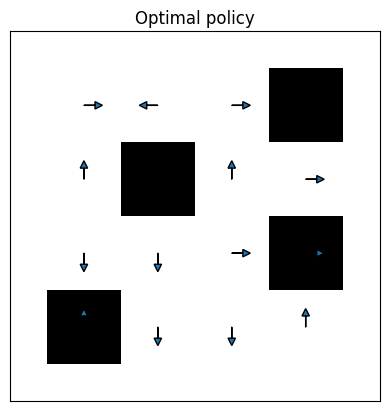

In [86]:
my_grid_test.plot_policy(Q)

**Plotting average return per episode against episodes sampled and wall clock time**

*Average return vs. episodes sampled*

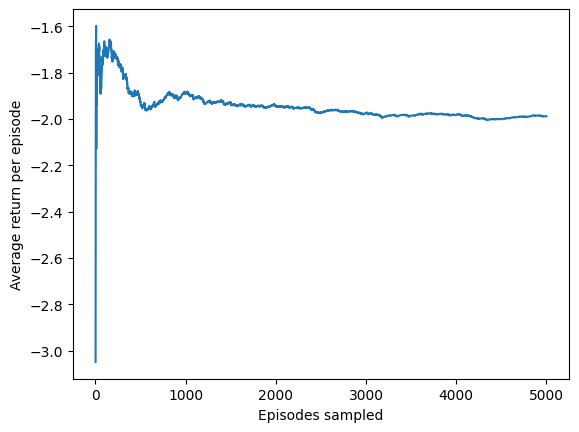

In [87]:
x = list(range(5000+1)[1:])
y = average_return_per_episode
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Average return per episode')
plt.show()

*Average return vs. wall clock time*

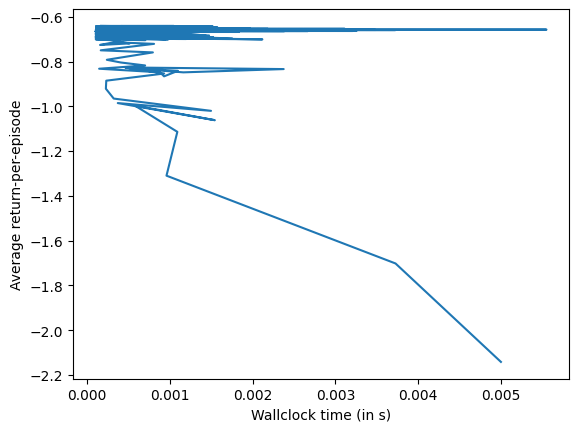

In [80]:
x = time_per_episode
y = average_return_per_episode
plt.plot(x,y)
plt.xlabel('Wallclock time')
plt.ylabel('Average return per episode')
plt.show()
     